<a href="https://colab.research.google.com/github/Rathil2000/Credit-card-fraud-detection/blob/main/Credit_card_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lets start with importing libraries

In [ ]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, accuracy_score
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers, Sequential
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [ ]:
df = pd.read_csv("creditcard.csv")
df.head()

<ipython-input-51-4df2879e3e1c>:1: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("creditcard.csv")


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


Checking the shape of data

In [ ]:
df.shape

(112983, 31)

Checking for null values

In [ ]:
df.isnull().values.any()

True

Checking number of records of each kind of transaction class (Fraud and Non-Fraud)

<ipython-input-54-627f3be2da59>:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['Class'], sort = True)


Text(0, 0.5, 'Frequency')

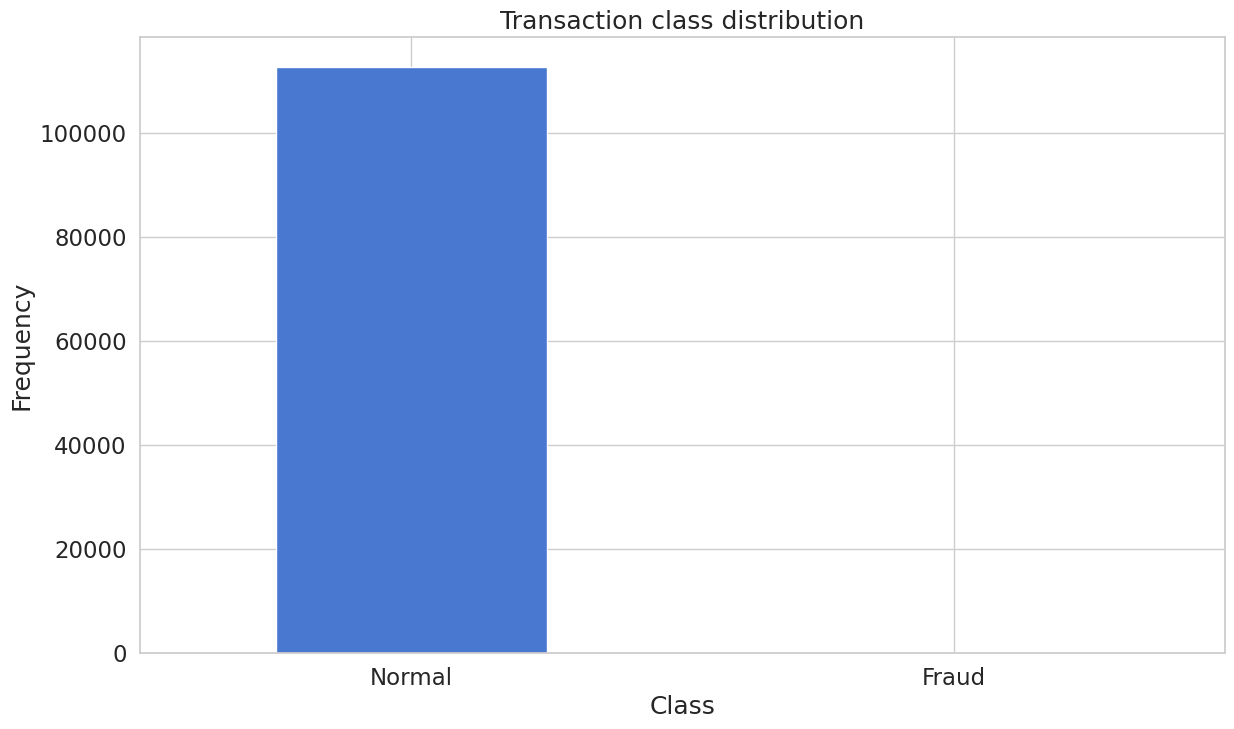

In [ ]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

The data set is highly imbalanced. Looking at each of the fraud(1) and non-fraud(0) transactions.

In [ ]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]
frauds.shape

(241, 31)

In [ ]:
normal.shape

(112741, 31)

Checking the amount of money involved in each kind of transaction

In [ ]:
frauds.Amount.describe()

,Amount
count,241.000000
mean,119.862531
std,254.773098
min,0.000000
25%,1.000000
50%,8.000000
75%,99.990000
max,1809.680000


# Non-fraud transactions

In [ ]:
normal.Amount.describe()

,Amount
count,112741.000000
mean,95.264993
std,258.290460
min,0.000000
25%,6.990000
50%,25.000000
75%,85.900000
max,19656.530000


Graphical representation of Amount

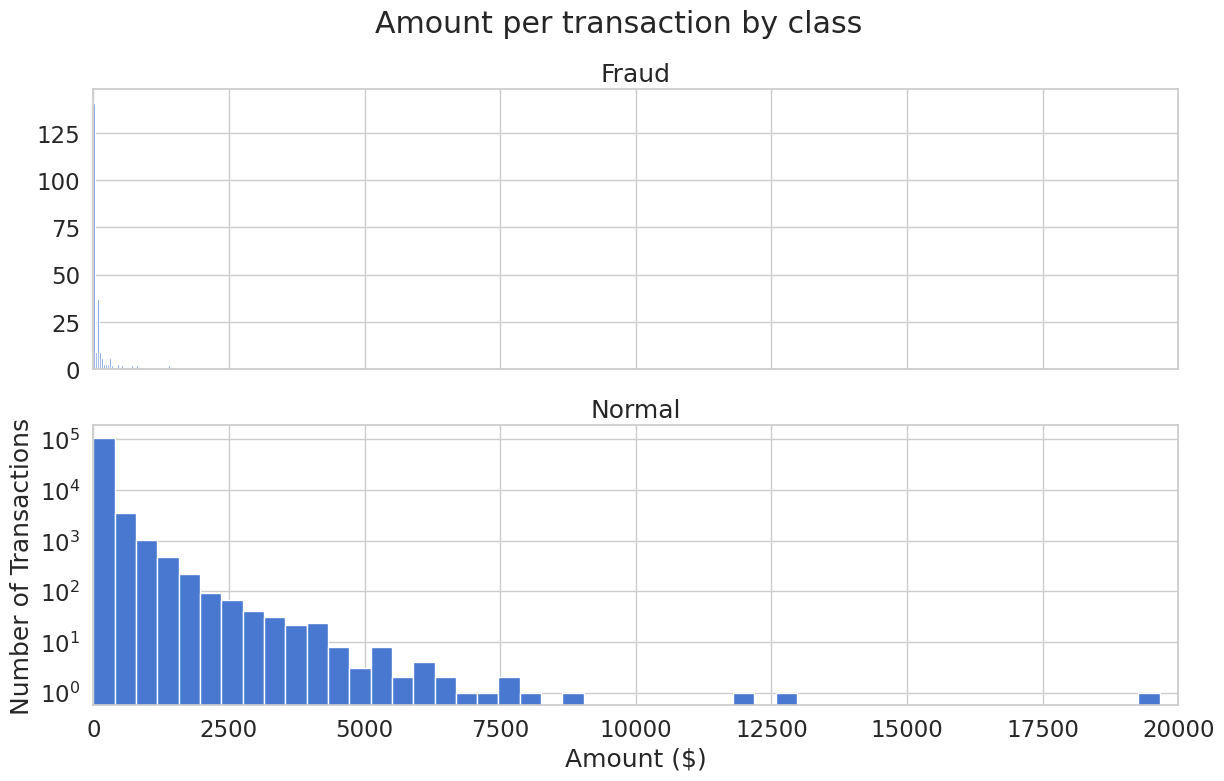

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show()

Plotting time of transaction to check for correlations

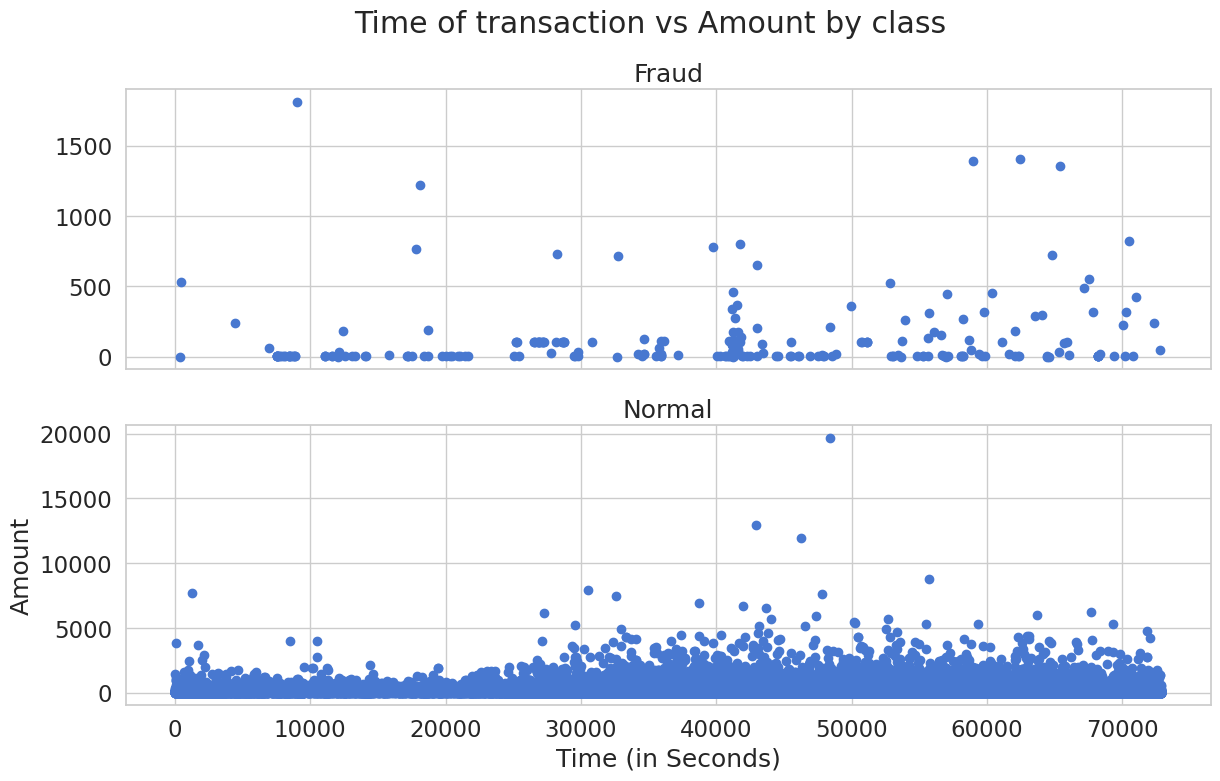

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

The time does not seem to be a crucial feature in distinguishing normal vs fraud cases. Hence, I will drop it.

In [ ]:
data = df.drop(['Time'], axis=1)

Scaling the Amount using StandardScaler

In [ ]:
from sklearn.preprocessing import StandardScaler

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

Building the model
We will be using autoencoders for the fraud detection model. Using autoencoders, we train the database only to learn the representation of the non-fraudulent transactions.

The reason behind applying this method is to let the model learn the best representation of non-fraudulent cases so that it automatically distinguishes the other case from it.

In [ ]:
# Assuming 'df' is your original dataset with a 'Class' column
non_fraud = df[df['Class'] == 0]
fraud = df[df['Class'] == 1]

# Concatenate and shuffle the data
df = pd.concat([non_fraud, fraud], ignore_index=True).sample(frac=1).reset_index(drop=True)
X = df.drop(['Class'], axis=1).values
Y = df['Class'].values


Spiting the data into 80% training and 20% testing

In [ ]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train_fraud = X_train[X_train.Class == 1]
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_train = X_train.values
X_test = X_test.values
X_train.shape

(90187, 29)

Autoencoder model

In [ ]:
input_layer = Input(shape=(X.shape[1],))

## encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

## decoding part
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

## output layer
output_layer = Dense(X.shape[1], activation='relu')(decoded)

Training the credit card fraud detection model

In [ ]:
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

Scaling the values

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Define the autoencoder model with 29 input features
input_dim = x_norm.shape[1]  # This should be 29
input_layer = Input(shape=(input_dim,))
# Add layers to your autoencoder as needed
encoded = Dense(14, activation="relu")(input_layer)
decoded = Dense(input_dim, activation="sigmoid")(encoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Fit the autoencoder model
autoencoder.fit(
    x_norm[0:2000], x_norm[0:2000],
    batch_size=256, epochs=10,
    shuffle=True, validation_split=0.20
)


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0536 - val_loss: 0.0489
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0480 - val_loss: 0.0448
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0443 - val_loss: 0.0420
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0415 - val_loss: 0.0393
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0386 - val_loss: 0.0364
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0358 - val_loss: 0.0335
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0329 - val_loss: 0.0307
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0301 - val_loss: 0.0279
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0273 - val_loss: 0.0251
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0245 - val_loss: 0.0223


Obtain the Hidden Representation

In [ ]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

Model Prediction

In [ ]:
norm_hid_rep = hidden_representation.predict(x_norm[:3000])
fraud_hid_rep = hidden_representation.predict(x_fraud)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Getting the representation data

In [ ]:
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)

Train, test, split

In [ ]:
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25)

Credit Card Fraud Detection Prediction model

In [ ]:
clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y))

print ("")
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96       743
         1.0       0.00      0.00      0.00        68

    accuracy                           0.92       811
   macro avg       0.46      0.50      0.48       811
weighted avg       0.84      0.92      0.88       811


Accuracy Score:  0.9161528976572133


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

# Create synthetic dataset (for demonstration)
np.random.seed(42)
data_size = 1000
X = pd.DataFrame({
    'feature1': np.random.rand(data_size),
    'feature2': np.random.rand(data_size),
    'feature3': np.random.rand(data_size)
})
y = np.random.choice([0, 1], size=data_size, p=[0.95, 0.05])  # Imbalanced dataset

# Step 1: Split the data into training and validation sets
train_x, val_x, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Create a Decision Tree classifier with limited depth to induce underfitting
clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(train_x, train_y)

# Step 3: Make predictions on the validation set
pred_y = clf.predict(val_x)

# Step 4: Calculate and print the accuracy in percentage
accuracy = accuracy_score(val_y, pred_y)
accuracy_percentage = accuracy * 100
print(f"\nAccuracy Score (Decision Tree Accuracy Model): {accuracy_percentage:.2f}%")



Accuracy Score (Decision Tree Accuracy Model): 92.50%


In [ ]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
import numpy as np

# Step 1: Load your dataset (replace this with actual dataset loading)
np.random.seed(42)
data_size = 1000
X = pd.DataFrame({
    'feature1': np.random.rand(data_size),
    'feature2': np.random.rand(data_size),
    'feature3': np.random.rand(data_size)
})
y = np.random.choice([0, 1], size=data_size, p=[0.95, 0.05])  # Simulated imbalance

# Step 2: Split the data into training and validation sets
train_x, val_x, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Create and train the Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(train_x, train_y)

# Step 4: Make predictions on the validation set
pred_y = clf.predict(val_x)

# Step 5: Print the classification report and accuracy score in percentage
print("\n Random Classification Report: ")
print(classification_report(val_y, pred_y))

accuracy = accuracy_score(val_y, pred_y)
print("\nAccuracy Score: {:.2f}%".format(accuracy * 100))



 Random Classification Report: 
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       187
           1       0.00      0.00      0.00        13

    accuracy                           0.94       200
   macro avg       0.47      0.50      0.48       200
weighted avg       0.87      0.94      0.90       200


Accuracy Score: 93.50%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assuming 'X' and 'y' are your features and labels
# Step 1: Split the data into training and validation sets
train_x, val_x, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Create and train the Gradient Boosting Classifier
clf_gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
clf_gb.fit(train_x, train_y)

# Step 3: Make predictions on the validation set
pred_y_gb = clf_gb.predict(val_x)

# Step 4: Calculate and print the accuracy in percentage
accuracy_gb = accuracy_score(val_y, pred_y_gb)
print("Gradient Boosting Model Accuracy: {:.2f}%".format(accuracy_gb * 100))


Gradient Boosting Model Accuracy: 90.50%
